In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

def calculate_profit(df_cuenta_corriente_historico):
    """
    Calcula la ganancia o perdida realizada para cada operacion de venta
    de activos a partir de un archivo CSV de cuenta corriente.

    Args:
        ruta_archivo_csv (str): La ruta al archivo CSV exportado del broker.

    Returns:
        pandas.DataFrame: Un DataFrame con el resultado de cada venta.
    """
    # Asegurarse que las columnas numericas sean floats
    for col in ['Cantidad', 'Precio', 'Importe']:
        if df_cuenta_corriente_historico[col].dtype == 'object':
            df_cuenta_corriente_historico[col] = df_cuenta_corriente_historico[col].str.replace(',', '', regex=False).astype(float)
        
    # strip a comprobante
    df_cuenta_corriente_historico['Comprobante'] = df_cuenta_corriente_historico['Comprobante'].str.strip()

    
    # Ordeno primero por Especie y luego por Operado
    df_cuenta_corriente_historico = df_cuenta_corriente_historico.sort_values(by=['Especie', 'Operado'], ascending=[True, True])

    # 2. Filtrar solo operaciones de compra y venta
    operaciones = df_cuenta_corriente_historico[df_cuenta_corriente_historico['Comprobante'].isin(['COMPRA NORMAL', 'VENTA', 'COMPRA EXTERIOR V', 'VENTA EXTERIOR V'])].copy()
    # operaciones = operaciones.sort_values(by='Operado', ascending=True)

    # 3. Logica principal: Iterar y calcular
    cartera = {}  # Diccionario para seguir el estado de cada activo
                    # Ejemplo: {'GGAL': {'cantidad': 100, 'costo_total': 45000}}
    resultados = [] # Lista para guardar los resultados de las ventas

    print("Procesando operaciones...")

    for index, op in operaciones.iterrows():
        especie = op['Especie']
        cantidad = op['Cantidad']
        importe = op['Importe']
        precio_op = op['Precio']

        # Inicializar el activo en la cartera si no existe
        if especie not in cartera and (op['Comprobante'] == 'VENTA' or op['Comprobante'] == 'VENTA EXTERIOR V'):
            print(f"ADVERTENCIA: Se intento vender {cantidad} de {especie}, pero no hay registro de compra. Se omitira.")
            continue

        elif especie not in cartera:
            cartera[especie] = {'cantidad_total': 0.0, 'costo_total': 0.0}

        # Si es una COMPRA
        if op['Comprobante'] == 'COMPRA NORMAL' or op['Comprobante'] == 'COMPRA EXTERIOR V':
            cartera[especie]['cantidad_total'] += abs(cantidad)
            cartera[especie]['costo_total'] += abs(importe) # El importe de compra es negativo
            # print(f"Actualizada cartera: {cartera[especie]['cantidad_total']} de {especie} a un costo total de ${cartera[especie]['costo_total']:.2f}.")
            print(f"Compra: {cantidad:.2f} de {especie} a ${precio_op:.2f}")


        # Si es una VENTA
        elif op['Comprobante'] == 'VENTA' or op['Comprobante'] == 'VENTA EXTERIOR V':
            if abs(cartera[especie]['cantidad_total']) < abs(cantidad):
                print(f"ADVERTENCIA: Se intento vender {cantidad} de {especie}, pero solo hay {cartera[especie]['cantidad_total']} en cartera. Se omitira.")
                cartera.pop(especie, None)
                print(f"Se elimino {especie} de la cartera por falta de cantidad suficiente.")
                continue

            # Calcular el Precio Promedio de Compra (PPC) al momento de la venta
            if cartera[especie]['cantidad_total'] > 0:
                ppc = cartera[especie]['costo_total'] / cartera[especie]['cantidad_total']
            else:
                ppc = 0 # Evitar division por cero

            # Calcular el costo de los activos vendidos
            costo_de_venta = ppc * abs(cantidad)
            # La ganancia es el importe de la venta (positivo) menos el costo
            ganancia_perdida = abs(importe) - abs(costo_de_venta)

            print(f"Venta: {cantidad:.2f} de {especie} a ${precio_op:.2f}. PPC: ${ppc:.2f}. Resultado: ${ganancia_perdida:.2f}")

            # Registrar el resultado de la operacion
            resultados.append({
                'Fecha Venta': op['Operado'],
                'Activo': especie,
                'Cantidad Vendida': cantidad,
                'Precio Venta': precio_op,
                'Precio Promedio Compra (PPC)': ppc,
                'Costo Total Venta': abs(costo_de_venta),
                'Ganancia/Perdida ($)': ganancia_perdida
            })

            # Actualizar la cartera despues de la venta
            cartera[especie]['cantidad_total'] -= abs(cantidad)
            cartera[especie]['costo_total'] -= abs(costo_de_venta)
            # print(f"Actualizada cartera: {cartera[especie]['cantidad_total']} de {especie} restantes.")

            # Si se vendio todo, se elimina la especie de la cartera
            if cartera[especie]['cantidad_total'] <= 0:
                cartera.pop(especie, None)
                print(f"Se elimino {especie} de la cartera por venta total.")


    print("\n¡Calculo finalizado!")
    df_results =  pd.DataFrame(resultados)

    print(f"Se procesaron {len(resultados)} operaciones de venta.")
    print(df_results)

    return df_results

In [2]:
%ls ../data/

cuenta_corriente_dolares_cable_historico.csv*  cuenta_corriente_historico.csv*
cuenta_corriente_dolares_historico.csv*        profit.csv*


# PESOS
## Ganancias realizadas por compra/venta de activos financieros

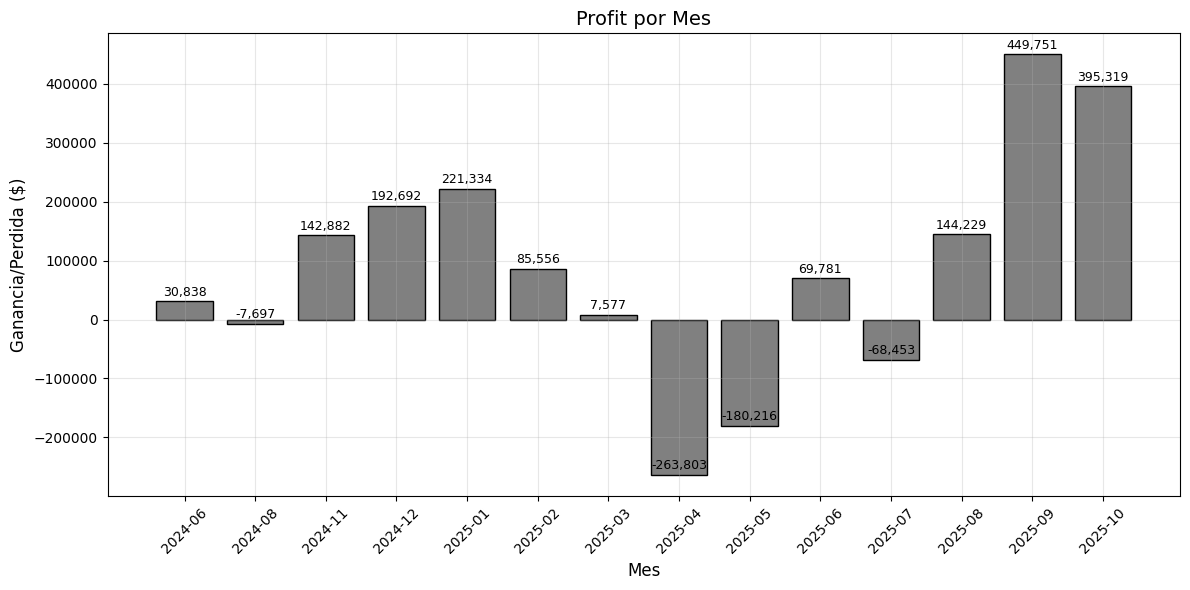

,Anio-Mes,Ganancia/Perdida ($)
0,2024-06,30837.65
1,2024-08,-7697.27
2,2024-11,142881.56
3,2024-12,192692.16
4,2025-01,221333.86
5,2025-02,85555.65
6,2025-03,7577.32
7,2025-04,-263803.17
8,2025-05,-180215.81
9,2025-06,69781.32


In [3]:
# leo el csv con pandas
df = pd.read_csv('../data/profit.csv', sep=',')

# me quedo solo con el año y el mes YYYY-MM de la columna Fecha Venta
df['Fecha Venta'] = pd.to_datetime(df['Fecha Venta'])
df['Anio-Mes'] = df['Fecha Venta'].dt.to_period('M')
# agrupo por Anio-Mes y calculo la suma de Profit
df_grouped_ganancias_perdidas_compra_venta = df.groupby('Anio-Mes')['Ganancia/Perdida ($)'].sum().reset_index()
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot
bars = ax.bar(range(len(df_grouped_ganancias_perdidas_compra_venta)), df_grouped_ganancias_perdidas_compra_venta['Ganancia/Perdida ($)'], 
              color='gray', edgecolor='black', width=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, df_grouped_ganancias_perdidas_compra_venta['Ganancia/Perdida ($)'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(df_grouped_ganancias_perdidas_compra_venta['Ganancia/Perdida ($)']) * 0.01),
            f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_title('Profit por Mes', fontsize=14)
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Ganancia/Perdida ($)', fontsize=12)
ax.set_xticks(range(len(df_grouped_ganancias_perdidas_compra_venta)))
ax.set_xticklabels(df_grouped_ganancias_perdidas_compra_venta['Anio-Mes'], rotation=45, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
df_grouped_ganancias_perdidas_compra_venta

## Ganancias perdidas por especie del mes

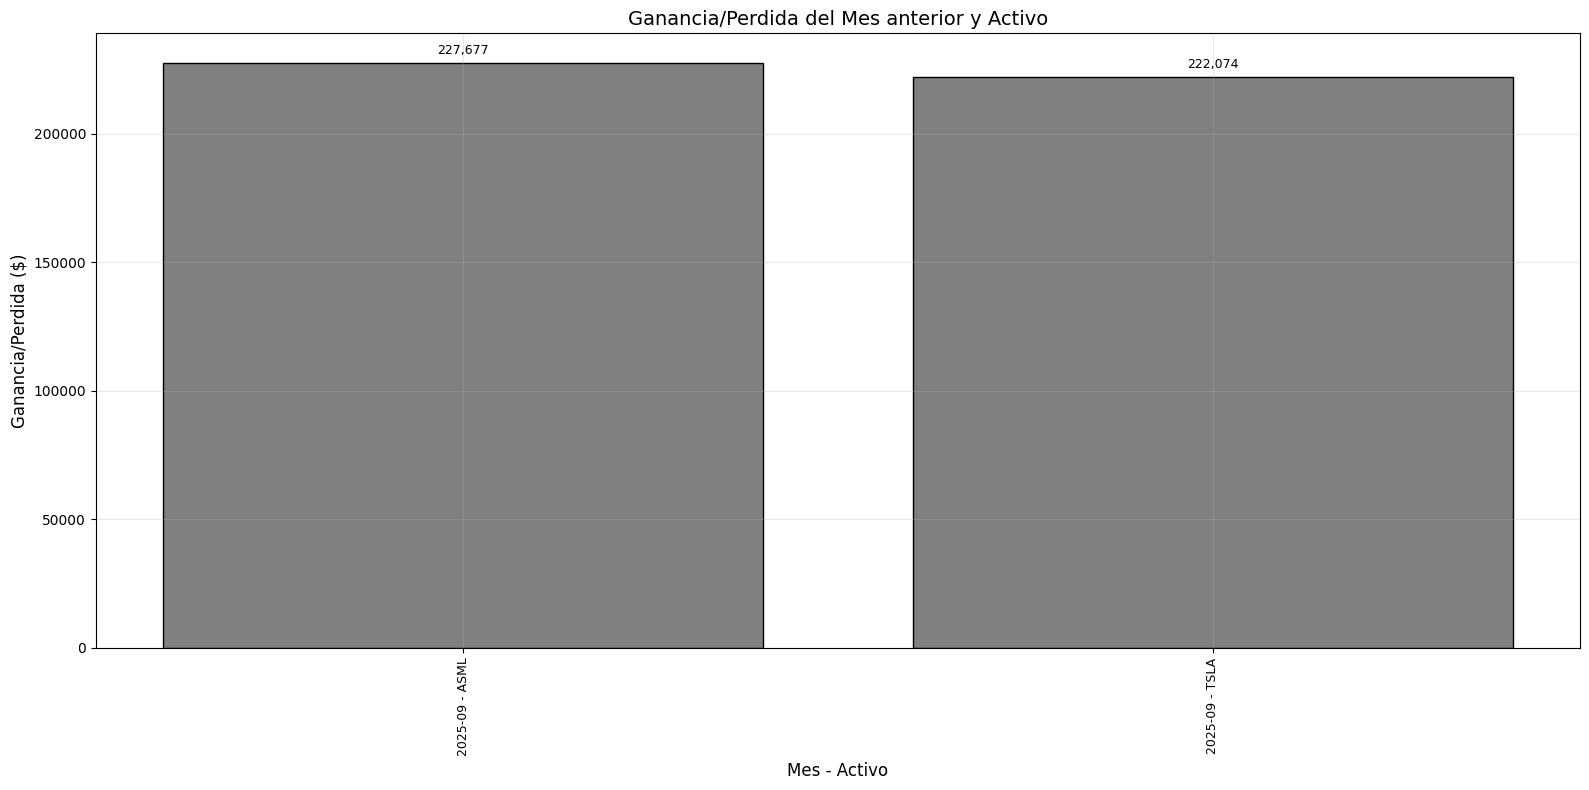

Ganancia total en el mes: 449,751


In [4]:
# Agrupo y ordeno por Anio-Mes y Activo
df_grouped_ganancias_perdidas_compra_venta_por_activo = (
    df.groupby(['Anio-Mes', 'Activo'])['Ganancia/Perdida ($)']
    .sum()
    .reset_index()
    .sort_values(['Anio-Mes', 'Activo'])
)

# filtro por el año y mes en curso
df_grouped_ganancias_perdidas_compra_venta_por_activo = df_grouped_ganancias_perdidas_compra_venta_por_activo[
    (df_grouped_ganancias_perdidas_compra_venta_por_activo['Anio-Mes'].dt.year == pd.Timestamp.now().year) &
    (df_grouped_ganancias_perdidas_compra_venta_por_activo['Anio-Mes'].dt.month == pd.Timestamp.now().month - 1)
]


fig, ax = plt.subplots(figsize=(16, 8))

# Genero etiquetas combinadas para el eje x
labels = df_grouped_ganancias_perdidas_compra_venta_por_activo.apply(
    lambda row: f"{row['Anio-Mes']} - {row['Activo']}", axis=1
)

bars = ax.bar(
    range(len(df_grouped_ganancias_perdidas_compra_venta_por_activo)),
    df_grouped_ganancias_perdidas_compra_venta_por_activo['Ganancia/Perdida ($)'],
    color='gray', edgecolor='black', width=0.8
)

for i, (bar, value) in enumerate(zip(bars, df_grouped_ganancias_perdidas_compra_venta_por_activo['Ganancia/Perdida ($)'])):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + (max(df_grouped_ganancias_perdidas_compra_venta_por_activo['Ganancia/Perdida ($)']) * 0.01),
        f'{value:,.0f}', ha='center', va='bottom', fontsize=9
    )

ax.set_title('Ganancia/Perdida del Mes anterior y Activo', fontsize=14)
ax.set_xlabel('Mes - Activo', fontsize=12)
ax.set_ylabel('Ganancia/Perdida ($)', fontsize=12)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f'Ganancia total en el mes: {df_grouped_ganancias_perdidas_compra_venta_por_activo["Ganancia/Perdida ($)"].sum():,.0f}')

# Ingresos por Dividendos o intereses

/tmp/ipykernel_1841/43551988.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ingresos_por_dividendos['Anio-Mes'] = pd.to_datetime(df_ingresos_por_dividendos['Liquida']).dt.to_period('M')


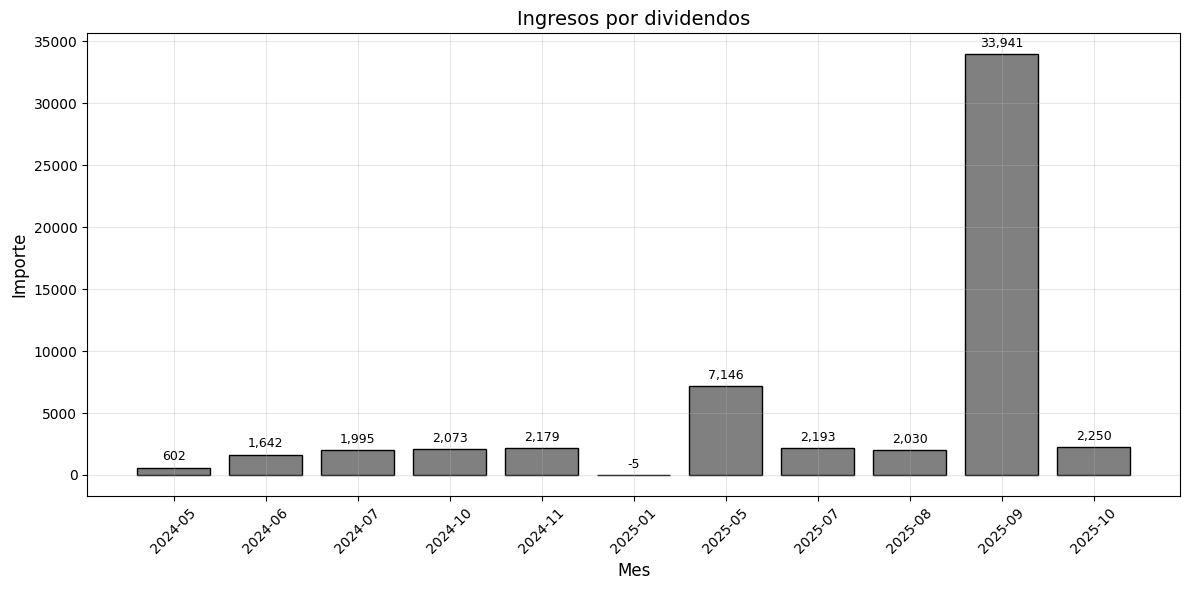

In [5]:
# leo el csv con pandas
df = pd.read_csv('../data/cuenta_corriente_historico.csv', sep=',')

# hago un distinct solo a la columna comprobante
df_comprobantes = df[['Comprobante']].drop_duplicates()

df_dividendos_e_intereses = df[df['Comprobante'].isin(['PAGO DIV', 'DIVIDENDOS', 'RETENCION', 'CREDITO DERMERC-', 'COMPRA CAUCION CONTADO', 'VENTA CAUCION TERMINO'])]

# df_comprobantes
# me quedo solo con DIVIDENDOS, CREDITO DERMERC-, RETENCION, PAGO DIV	
df_dividendos = df_dividendos_e_intereses[df_dividendos_e_intereses['Comprobante'].isin(['PAGO DIV', 'DIVIDENDOS', 'RETENCION', 'CREDITO DERMERC-'])]

# me quedo con las columnas Liquida, e Importe
df_ingresos_por_dividendos = df_dividendos[['Liquida', 'Importe']]

# a la columna Liquida le saco el día y la dejo solo con el mes y el año en formato YYYY-MM
df_ingresos_por_dividendos['Anio-Mes'] = pd.to_datetime(df_ingresos_por_dividendos['Liquida']).dt.to_period('M')

df_ingresos_por_dividendos = df_ingresos_por_dividendos[['Anio-Mes', 'Importe']]

# agrupo por mes y sumo los importes
df_ingresos_por_dividendos = df_ingresos_por_dividendos.groupby('Anio-Mes').sum().reset_index()


fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot
bars = ax.bar(range(len(df_ingresos_por_dividendos)), df_ingresos_por_dividendos['Importe'], 
              color='gray', edgecolor='black', width=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, df_ingresos_por_dividendos['Importe'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(df_ingresos_por_dividendos['Importe']) * 0.01),
            f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_title('Ingresos por dividendos', fontsize=14)
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Importe', fontsize=12)
ax.set_xticks(range(len(df_ingresos_por_dividendos)))
ax.set_xticklabels(df_ingresos_por_dividendos['Anio-Mes'], rotation=45, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Intereses de caución

/tmp/ipykernel_1841/1080037767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intereses_por_caucion['Anio-Mes'] = pd.to_datetime(df_intereses_por_caucion['Operado']).dt.to_period('M')


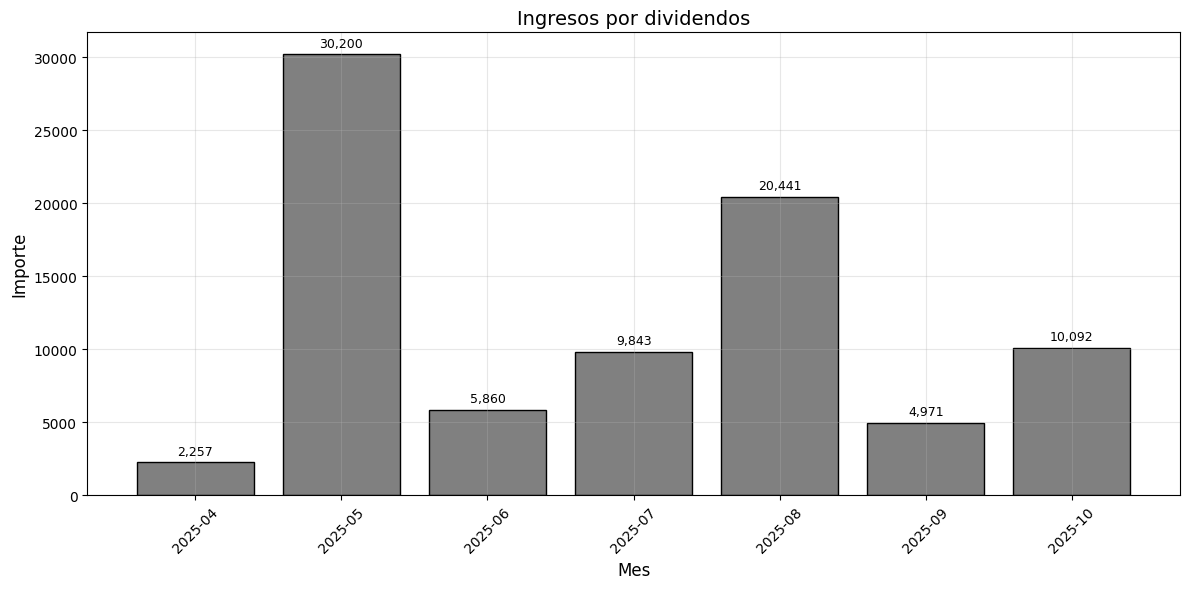

In [6]:
df_intereses_por_caucion = df[df['Comprobante'].isin(['COMPRA CAUCION CONTADO', 'VENTA CAUCION TERMINO'])]

df_intereses_por_caucion['Anio-Mes'] = pd.to_datetime(df_intereses_por_caucion['Operado']).dt.to_period('M')
df_intereses_por_caucion = df_intereses_por_caucion[['Anio-Mes', 'Importe']]
df_intereses_por_caucion = df_intereses_por_caucion.groupby('Anio-Mes').sum().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot
bars = ax.bar(range(len(df_intereses_por_caucion)), df_intereses_por_caucion['Importe'], 
              color='gray', edgecolor='black', width=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, df_intereses_por_caucion['Importe'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(df_intereses_por_caucion['Importe']) * 0.01),
            f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_title('Ingresos por dividendos', fontsize=14)
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Importe', fontsize=12)
ax.set_xticks(range(len(df_intereses_por_caucion)))
ax.set_xticklabels(df_intereses_por_caucion['Anio-Mes'], rotation=45, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Total de ganancia perdida realizadas por compra/venta de activos, dividendos e intereses.

In [7]:
# df_intereses_por_caucion
# df_ingresos_por_dividendos
# df_grouped_ganancias_perdidas_compra_venta
# renombro Ganancia/Perdida ($) por Importe
df_grouped_ganancias_perdidas_compra_venta.rename(columns={'Ganancia/Perdida ($)': 'Importe'}, inplace=True)

# hago un merge de los tres dataframes por Anio-Mes
df_total_ganancias_perdidas = df_grouped_ganancias_perdidas_compra_venta.merge(df_ingresos_por_dividendos, on='Anio-Mes', how='outer', suffixes=('_compra_venta', '_dividendos'))
df_total_ganancias_perdidas = df_total_ganancias_perdidas.merge(df_intereses_por_caucion, on='Anio-Mes', how='outer', suffixes=('', '_intereses'))  

df_total_ganancias_perdidas['Importe_sum'] = df_total_ganancias_perdidas['Importe_compra_venta'].fillna(0) + df_total_ganancias_perdidas['Importe_dividendos'].fillna(0) + df_total_ganancias_perdidas['Importe'].fillna(0)
df_total_ganancias_perdidas

,Anio-Mes,Importe_compra_venta,Importe_dividendos,Importe,Importe_sum
0,2024-05,NaN,602.33,NaN,602.33
1,2024-06,30837.65,1642.32,NaN,32479.97
2,2024-07,NaN,1994.71,NaN,1994.71
3,2024-08,-7697.27,NaN,NaN,-7697.27
4,2024-10,NaN,2072.85,NaN,2072.85
5,2024-11,142881.56,2179.15,NaN,145060.71
6,2024-12,192692.16,NaN,NaN,192692.16
7,2025-01,221333.86,-5.43,NaN,221328.43
8,2025-02,85555.65,NaN,NaN,85555.65
9,2025-03,7577.32,NaN,NaN,7577.32


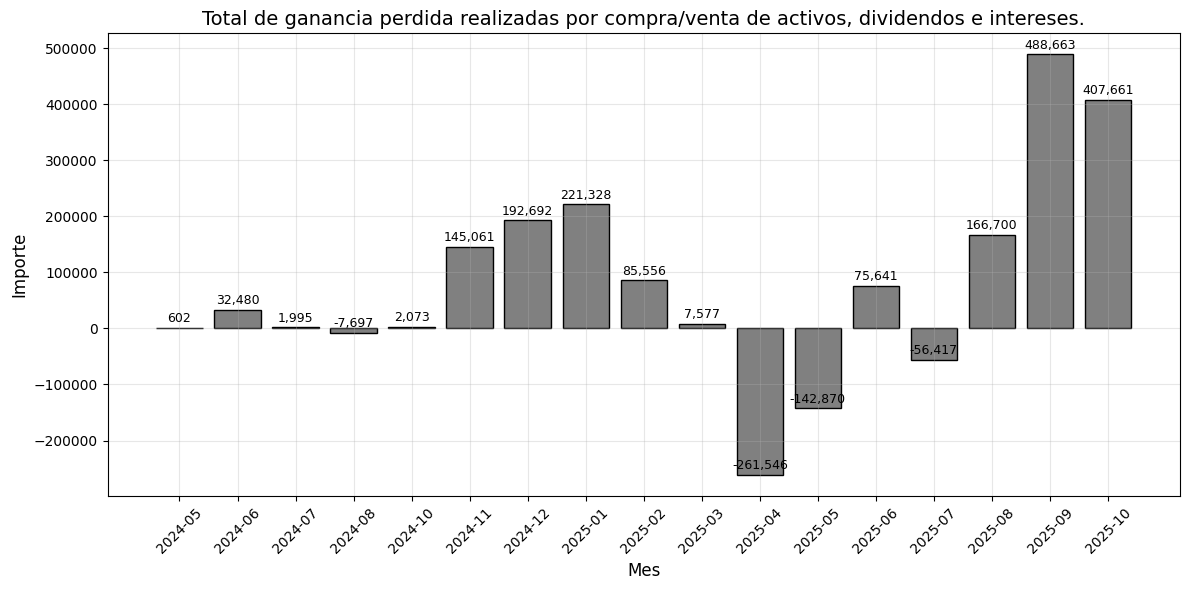

In [8]:
df_total_ganancias_perdidas_to_plot = df_total_ganancias_perdidas[['Anio-Mes', 'Importe_sum']].rename(columns={'Importe_sum': 'Importe'})

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot
bars = ax.bar(range(len(df_total_ganancias_perdidas_to_plot)), df_total_ganancias_perdidas_to_plot['Importe'], 
              color='gray', edgecolor='black', width=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, df_total_ganancias_perdidas_to_plot['Importe'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(df_total_ganancias_perdidas_to_plot['Importe']) * 0.01),
            f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_title('Total de ganancia perdida realizadas por compra/venta de activos, dividendos e intereses.', fontsize=14)
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Importe', fontsize=12)
ax.set_xticks(range(len(df_total_ganancias_perdidas_to_plot)))
ax.set_xticklabels(df_total_ganancias_perdidas_to_plot['Anio-Mes'], rotation=45, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
print('Promedio de ganancias/perdidas por mes:', df_total_ganancias_perdidas_to_plot['Importe'].mean())

Promedio de ganancias/perdidas por mes: 79970.54000000001


# DOLARES

       Operado  Importe
5   2025-01-09    41.78
21  2025-03-26    10.24


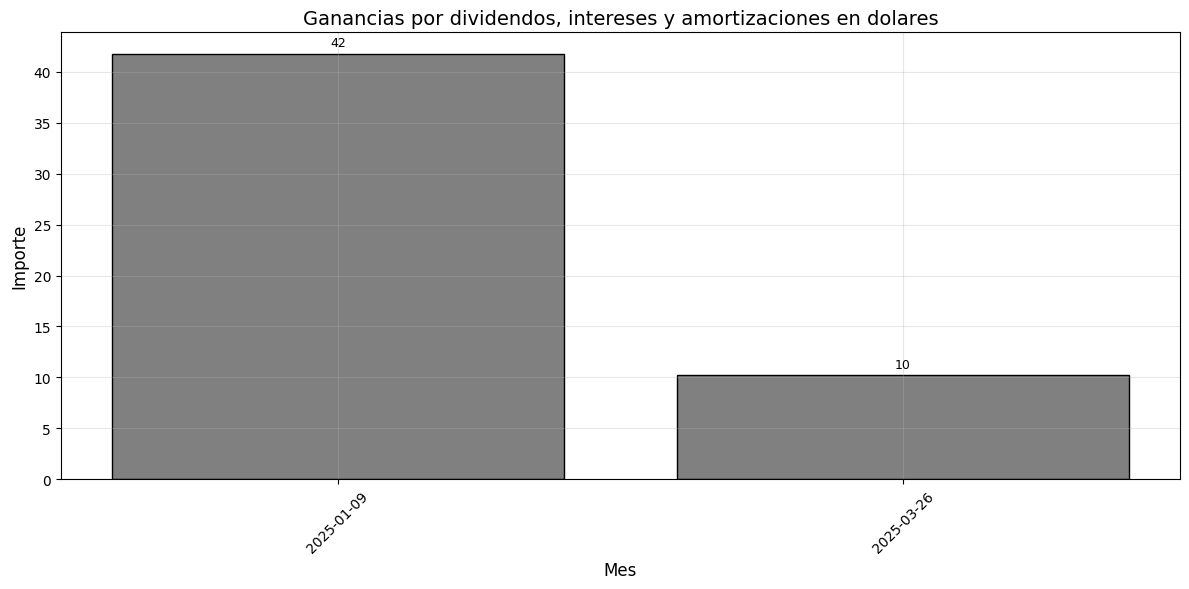

In [10]:
# leo el csv con pandas
df_cuenta_corriente_dolares_historico = pd.read_csv('../data/cuenta_corriente_dolares_historico.csv', sep=',')

# me quedo solo con las filas que Comprobante sea 'DIVIDENDOS' y 'RENTA Y AMORTIZ'
df_cuenta_corriente_dolares_historico = df_cuenta_corriente_dolares_historico[df_cuenta_corriente_dolares_historico['Comprobante'].isin(['DIVIDENDOS', 'RENTA Y AMORTIZ'])]

df_cuenta_corriente_dolares_historico = df_cuenta_corriente_dolares_historico[['Operado', 'Importe']]

df_cuenta_corriente_dolares_historico = df_cuenta_corriente_dolares_historico.sort_values(by=['Operado'], ascending=[True])

print(df_cuenta_corriente_dolares_historico)

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot
bars = ax.bar(range(len(df_cuenta_corriente_dolares_historico)), df_cuenta_corriente_dolares_historico['Importe'], 
              color='gray', edgecolor='black', width=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, df_cuenta_corriente_dolares_historico['Importe'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(df_cuenta_corriente_dolares_historico['Importe']) * 0.01),
            f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_title('Ganancias por dividendos, intereses y amortizaciones en dolares', fontsize=14)
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Importe', fontsize=12)
ax.set_xticks(range(len(df_cuenta_corriente_dolares_historico)))
ax.set_xticklabels(df_cuenta_corriente_dolares_historico['Operado'], rotation=45, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# DOLARES CABLE

## Ganancia y perdidas por compra/venta de activos

Procesando operaciones...
Compra: 10.00 de INTC.US a $24.77
Compra: 6.00 de INTC.US a $19.32
Venta: -6.00 de INTC.US a $23.75. PPC: $22.73. Resultado: $6.18
Venta: -5.00 de INTC.US a $23.39. PPC: $22.73. Resultado: $3.31
Venta: -5.00 de INTC.US a $20.62. PPC: $22.73. Resultado: $-10.50
Se elimino INTC.US de la cartera por venta total.
ADVERTENCIA: Se intento vender -11.0 de KO.US, pero no hay registro de compra. Se omitira.
ADVERTENCIA: Se intento vender -2.0 de KO.US, pero no hay registro de compra. Se omitira.
ADVERTENCIA: Se intento vender -3.0 de KO.US, pero no hay registro de compra. Se omitira.
ADVERTENCIA: Se intento vender -2.0 de KO.US, pero no hay registro de compra. Se omitira.
ADVERTENCIA: Se intento vender -1.0 de KO.US, pero no hay registro de compra. Se omitira.
ADVERTENCIA: Se intento vender -16.0 de KO.US, pero no hay registro de compra. Se omitira.
ADVERTENCIA: Se intento vender -4.0 de KO.US, pero no hay registro de compra. Se omitira.
ADVERTENCIA: Se intento vender 

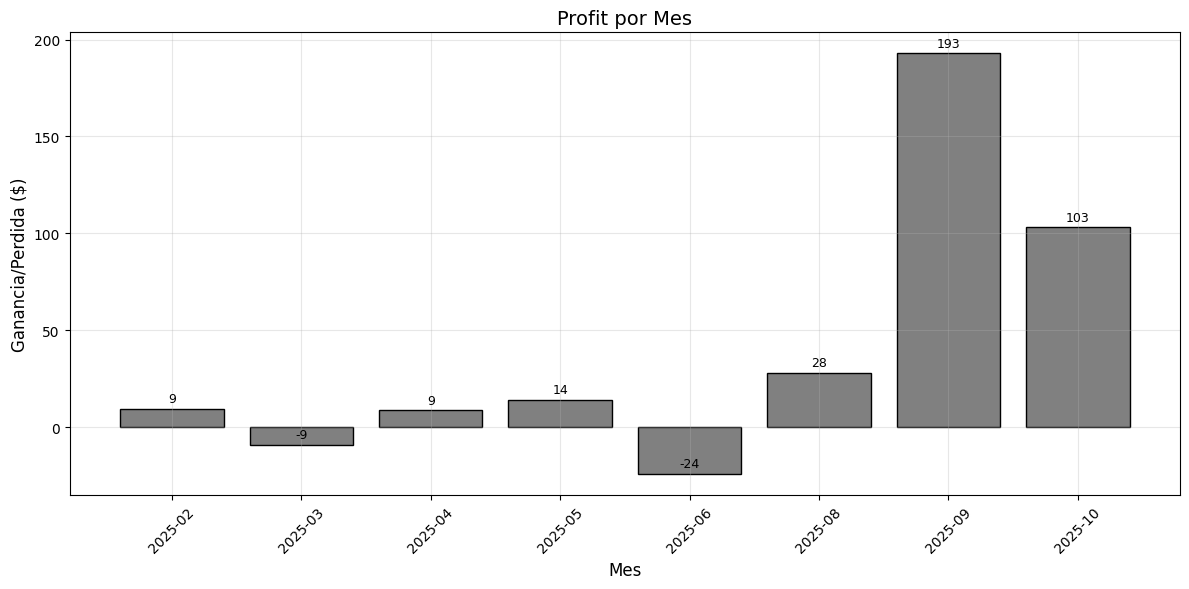

In [11]:
df_cuenta_corriente_dolares_cable_historico = pd.read_csv('../data/cuenta_corriente_dolares_cable_historico.csv', sep=',')
df_profit = calculate_profit(df_cuenta_corriente_dolares_cable_historico)
df_profit

df_profit['Fecha Venta'] = pd.to_datetime(df_profit['Fecha Venta'])
df_profit['Anio-Mes'] = df_profit['Fecha Venta'].dt.to_period('M')
# agrupo por Anio-Mes y calculo la suma de Profit
df_profit_grouped_ganancias_perdidas_compra_venta = df_profit.groupby('Anio-Mes')['Ganancia/Perdida ($)'].sum().reset_index()

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot
bars = ax.bar(range(len(df_profit_grouped_ganancias_perdidas_compra_venta)), df_profit_grouped_ganancias_perdidas_compra_venta['Ganancia/Perdida ($)'], 
              color='gray', edgecolor='black', width=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, df_profit_grouped_ganancias_perdidas_compra_venta['Ganancia/Perdida ($)'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(df_profit_grouped_ganancias_perdidas_compra_venta['Ganancia/Perdida ($)']) * 0.01),
            f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_title('Profit por Mes', fontsize=14)
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Ganancia/Perdida ($)', fontsize=12)
ax.set_xticks(range(len(df_profit_grouped_ganancias_perdidas_compra_venta)))
ax.set_xticklabels(df_profit_grouped_ganancias_perdidas_compra_venta['Anio-Mes'], rotation=45, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Ganancias por especie

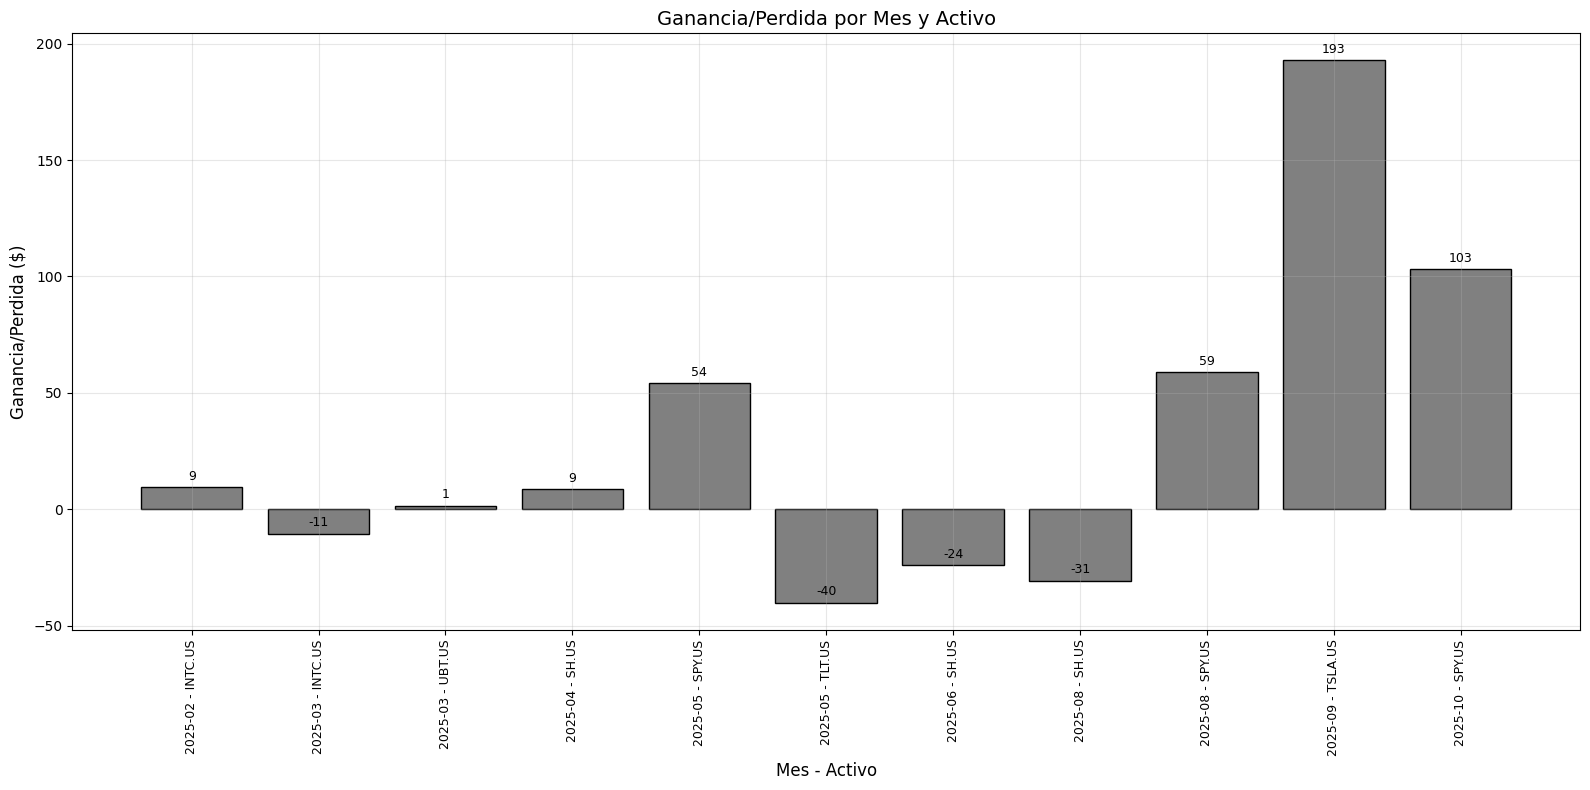

In [12]:
# Agrupo y ordeno por Anio-Mes y Activo
df_profit_grouped_ganancias_perdidas_compra_venta = (
    df_profit.groupby(['Anio-Mes', 'Activo'])['Ganancia/Perdida ($)']
    .sum()
    .reset_index()
    .sort_values(['Anio-Mes', 'Activo'])
)

fig, ax = plt.subplots(figsize=(16, 8))

# Genero etiquetas combinadas para el eje x
labels = df_profit_grouped_ganancias_perdidas_compra_venta.apply(
    lambda row: f"{row['Anio-Mes']} - {row['Activo']}", axis=1
)

bars = ax.bar(
    range(len(df_profit_grouped_ganancias_perdidas_compra_venta)),
    df_profit_grouped_ganancias_perdidas_compra_venta['Ganancia/Perdida ($)'],
    color='gray', edgecolor='black', width=0.8
)

for i, (bar, value) in enumerate(zip(bars, df_profit_grouped_ganancias_perdidas_compra_venta['Ganancia/Perdida ($)'])):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + (max(df_profit_grouped_ganancias_perdidas_compra_venta['Ganancia/Perdida ($)']) * 0.01),
        f'{value:,.0f}', ha='center', va='bottom', fontsize=9
    )

ax.set_title('Ganancia/Perdida por Mes y Activo', fontsize=14)
ax.set_xlabel('Mes - Activo', fontsize=12)
ax.set_ylabel('Ganancia/Perdida ($)', fontsize=12)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Ganancias por dividendos, intereses y amortizaciones en dolares cable

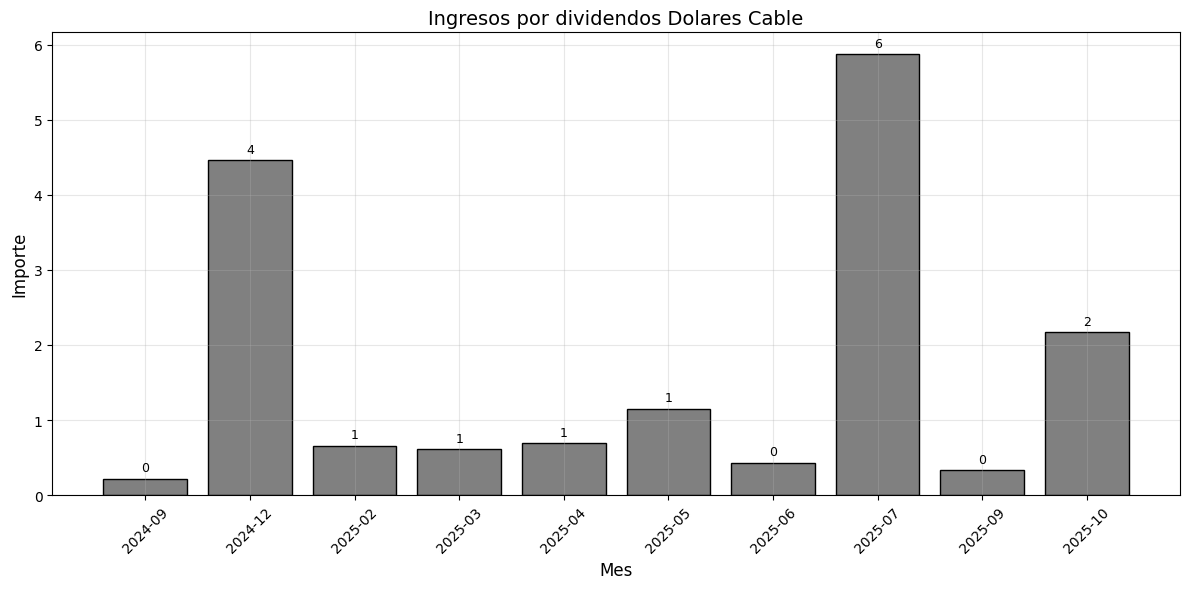

,Anio-Mes,Importe
0,2024-09,0.22
1,2024-12,4.46
2,2025-02,0.66
3,2025-03,0.61
4,2025-04,0.69
5,2025-05,1.15
6,2025-06,0.43
7,2025-07,5.87
8,2025-09,0.33
9,2025-10,2.17


In [13]:
df_cuenta_corriente_dolares_cable_historico = pd.read_csv('../data/cuenta_corriente_dolares_cable_historico.csv', sep=',')
df_dividendos_dolares = df_cuenta_corriente_dolares_cable_historico[df_cuenta_corriente_dolares_cable_historico['Comprobante'].isin(['DIVIDENDOS', 'RETENCION DOLARES', 'DIVIDENDO TESORO'])]

# me quedo con las columnas Liquida, e Importe
df_dividendos_dolares = df_dividendos_dolares[['Liquida', 'Importe']]

# a la columna Liquida le saco el día y la dejo solo con el mes y el año en formato YYYY-MM
df_dividendos_dolares['Anio-Mes'] = pd.to_datetime(df_dividendos_dolares['Liquida']).dt.to_period('M')

df_dividendos_dolares = df_dividendos_dolares[['Anio-Mes', 'Importe']]

# agrupo por mes y sumo los importes
df_dividendos_dolares = df_dividendos_dolares.groupby('Anio-Mes').sum().reset_index()


fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot
bars = ax.bar(range(len(df_dividendos_dolares)), df_dividendos_dolares['Importe'], 
              color='gray', edgecolor='black', width=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, df_dividendos_dolares['Importe'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(df_dividendos_dolares['Importe']) * 0.01),
            f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_title('Ingresos por dividendos Dolares Cable', fontsize=14)
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Importe', fontsize=12)
ax.set_xticks(range(len(df_dividendos_dolares)))
ax.set_xticklabels(df_dividendos_dolares['Anio-Mes'], rotation=45, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

df_dividendos_dolares